In [25]:
import os 
import numpy as np
from icecream import ic
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

In [26]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/optim"

# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [27]:
import urllib.request
# from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial4/"
# Files to download
pretrained_files = ["FashionMNIST_SGD.config",    "FashionMNIST_SGD_results.json",    "FashionMNIST_SGD.tar",
                    "FashionMNIST_SGDMom.config", "FashionMNIST_SGDMom_results.json", "FashionMNIST_SGDMom.tar",
                    "FashionMNIST_Adam.config",   "FashionMNIST_Adam_results.json",   "FashionMNIST_Adam.tar"   ]
os.makedirs(CHECKPOINT_PATH, exist_ok=True)
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name) 
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        ic('downloading the file....')
        urllib.request.urlretrieve(file_url, file_path)



In [28]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.2861, ), (0.3530, ))])
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform)
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])
train_dataloader = torch.utils.data.DataLoader(dataset=train_set, batch_size=1024, shuffle=True, drop_last=False)
val_dataloader = torch.utils.data.DataLoader(dataset=val_set, batch_size=1024, shuffle=True, drop_last=False)
test_dataloader = torch.utils.data.DataLoader(dataset=test_set, batch_size=1024, shuffle=True, drop_last=False)

In [43]:
imgs, labels = next(iter(test_dataloader))
imgs.requires_grad

False

In [29]:
(train_dataset.data.float()/255.0).mean().item(), (train_dataset.data.float()/255.0).std().item()

(0.28604060411453247, 0.3530242443084717)

In [30]:
imgs, labels = next(iter(train_dataloader))
imgs.shape, imgs.mean(), imgs.std()

(torch.Size([1024, 1, 28, 28]), tensor(0.0203), tensor(1.0107))

In [100]:
class BaseNetwork(nn.Module):
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_size=[512, 256, 256, 128]):
        super().__init__()
        layers = []
        layers_size = [input_size] + hidden_size 
        for layer_idx in range(1, len(layers_size)):
            layers +=  [nn.Linear(layers_size[layer_idx-1], layers_size[layer_idx]), act_fn]
        layers+= [nn.Linear(layers_size[-1], num_classes)]
        # ic(layers)
        self.layers = nn.ModuleList(layers) 
        self.config = {'act_fn':{'name':act_fn}, 'input_size':input_size, 'num_classes':num_classes, 'hidden_size':hidden_size}

    # def forward(self, x):                           
    #     x = x.view(x.shape[0], -1)
    #     x = self.layers(x)
    #     return x 

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            x = layer(x)
        return x


In [64]:
bn = BaseNetwork(nn.ReLU())
bn.layers

ModuleList(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=128, bias=True)
  (7): ReLU()
  (8): Linear(in_features=128, out_features=10, bias=True)
)

In [33]:
class Identity(nn.Module):
    def forward(self, x):
        return x

In [34]:
act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "identity": Identity
}

In [101]:
def plot_dists(val_dict, color='C0', xlabel=None, stat='count', use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index%columns]
        sns.histplot(val_dict[key], ax=key_ax, color=color, bins=50, stat=stat, kde=use_kde and ((val_dict[key].max()-val_dict[key].min()>1e-8)))
        key_ax.set_title(f"{key} " + (r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape)>1 else ""))
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig

In [102]:
def visualize_activation(net):
    net.eval()
    # for name, param in net.named_parameters(): 
    #     if 'weight' not in name: 
    #         ic(name)
    ic.disable()      
    activations = {}
    imgs, labels = next(iter(test_dataloader))
    imgs, labels = imgs.to(device), labels.to(device)
    imgs = imgs.view(imgs.shape[0], -1)
    ic(imgs.shape, labels.shape)
    ic(imgs.requires_grad, labels.requires_grad)    
    for layer_idx, layer in enumerate(net.layers[:-1]):
        ic(layer_idx, layer)
        with torch.no_grad():
            imgs = layer(imgs)
            ic(imgs.shape, labels.shape)
            if isinstance(layer, nn.Linear):
                activations[layer_idx] = imgs.view(-1).detach().cpu().numpy()
    fig = plot_dists(activations, stat='density', xlabel='Activation')
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()
    # variance
    ic.enable()
    for key in activations.keys():
        ic(key, np.var(activations[key]))


In [109]:
def visualize_grad(net):
    net.eval()
    gradients = {}
    # optim = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    loss_module = nn.CrossEntropyLoss()
    imgs, labels = next(iter(test_dataloader))
    imgs, labels = imgs.to(device), labels.to(device)
    imgs = imgs.view(imgs.shape[0], -1)
    # optim.zero_grad()
    net.zero_grad()
    preds = net(imgs)
    ic(preds.shape, labels.shape)       
    preds = torch.argmax(preds, dim=-1)
    ic(preds.shape, labels.shape)
    loss = loss_module(preds, labels)
    loss.backward()

    for name, param in net.named_parameters():
        ic(name, param.data.grad().shape)
    # gradients = 
    # fig = plot_dists(gradients, stat='density', xlabel='Gradients')
    # fig.suptitle("Gradients distribution", fontsize=14, y=1.05)
    # plt.show()
    # plt.close()

In [110]:
bn_relu = BaseNetwork(nn.ReLU()).to(device)
visualize_grad(bn_relu)

ic| preds.shape: torch.Size([1024, 10])
    labels.shape: torch.Size([1024])
ic| preds.shape: torch.Size([1024]), labels.shape: torch.Size([1024])


RuntimeError: Expected floating point type for target with class probabilities, got Long

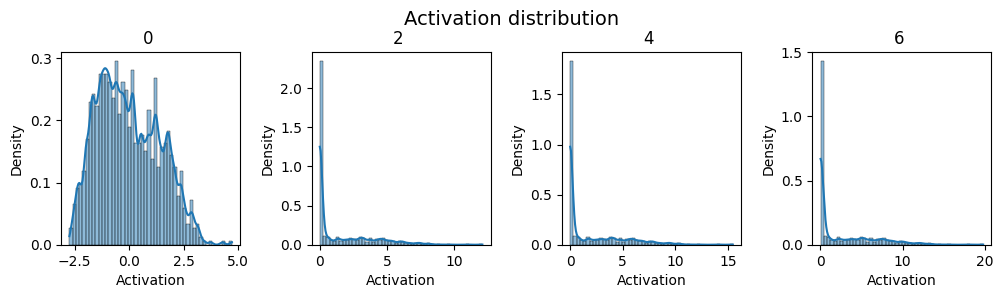

ic| key: 0, np.var(activations[key]): 1.9834065
ic| key: 2, np.var(activations[key]): 4.766179
ic| key: 4, np.var(activations[key]): 7.808906
ic| key: 6, np.var(activations[key]): 12.794113


In [89]:
bn_relu = BaseNetwork(nn.ReLU()).to(device)
# visualize_activation(bn)
bn_identity = BaseNetwork(Identity()).to(device)
# visualize_activation(bn_identity)
const_init(bn_relu, w=0.005)
# const_init(bn_identity, w=0.005)
# visualize_activation(bn_identity)
visualize_activation(bn_relu)

In [84]:
def const_init(net, w=0.0):
    for name, param in net.named_parameters():
        param.data.fill_(w)
